### Objective -- move center of image from Seattle to UBC 

We want to take an image centered on Seattle and move the image center to UBC

In [1]:
from e582utils.data_read import download

import numpy as np
import h5py
import warnings
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import seaborn as sns
from e582lib.modis_chans import chan_dict
from e582lib.channels_reproject import subsample,find_corners
from e582lib.channels_reproject import resample_channels
from e582lib.map_slices import get_corners_centered, make_basemap_xy,make_xy
import pyproj
from affine import Affine
from rasterio.warp import calculate_default_transform
from rasterio.warp import reproject, Resampling
warnings.filterwarnings("ignore")

#### convenience function to take lon,lat to row and column

In [2]:
def lon_lat_to_row_col(lon,lat,transform,projection):
    x,y=projection(lon,lat)
    col,row = ~transform*(x,y)
    return col,row

In [3]:
myd02file="MYD021KM.A2016224.2100.006.2016225153002.h5"
download(myd02file)
myd03file="MYD03.A2016224.2100.006.2016225152335.h5"
download(myd03file)
%matplotlib inline

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MYD021KM.A2016224.2100.006.2016225153002.h5
writing to: MYD021KM.A2016224.2100.006.2016225153002.h5

MYD021KM.A2016224.2100.006.2016225153002.h5 already exists
and is 159039295 bytes
will not overwrite

trying https://clouds.eos.ubc.ca/~phil/courses/atsc301/downloads/MYD03.A2016224.2100.006.2016225152335.h5
writing to: MYD03.A2016224.2100.006.2016225152335.h5

MYD03.A2016224.2100.006.2016225152335.h5 already exists
and is 40795456 bytes
will not overwrite



In [4]:
chan_list=['1','2','3','4']
reflectivity_list=[]
for the_chan in chan_list:
    #
    # read channel channels
    #
    index = chan_dict[the_chan]['index']
    field_name = chan_dict[the_chan]['field_name']
    scale_name = chan_dict[the_chan]['scale']
    offset_name = chan_dict[the_chan]['offset']
    with h5py.File(myd02file, 'r') as h5_file:
        chan = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][field_name][
            index, :, :]
        scale = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[scale_name][...]
        offset = h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][
            field_name].attrs[offset_name][...]
        chan_calibrated = (chan - offset[index]) * scale[index]
        chan_calibrated = chan_calibrated.astype(
            np.float32)  #convert from 64 bit to 32bit to save space
        reflectivity_list.append(chan_calibrated)

with h5py.File(myd03file) as geo_file:
        lon_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Longitude'][...]
        lat_data = geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields'][
            'Latitude'][...]

In [5]:
llcrnr=dict(lat=45,lon= -125)
urcrnr=dict(lat=50,lon= -120)
subsample_list=subsample(*reflectivity_list,lats=lat_data,lons=lon_data,llcrnr=llcrnr,urcrnr=urcrnr)
lats,lons=subsample_list[:2]
numchans=len(subsample_list) -2
rows,cols=lats.shape
chan_array=np.empty([rows,cols,numchans],dtype=np.float32)
for chan in range(numchans):
    chan_array[:,:,chan]=subsample_list[chan+2]

In [6]:
corner_dict=find_corners(subsample_list[0],subsample_list[1])
corner_dict

{'lat_0': 47.459999084472656,
 'lat_list': [44.227749, 50.692249],
 'llcrnrlat': 44.227749,
 'llcrnrlon': -127.23767,
 'lon_0': -122.78046417236328,
 'lon_list': [-127.23767, -118.32326],
 'urcrnrlat': 50.692249,
 'urcrnrlon': -118.32326}

In [7]:
chan_list=['1','2','3','4']
result_dict= resample_channels(chan_array,lats,lons,corner_dict)
#
# add ndvi as a new layer so that channels
# grows to shape= rows x cols x 5
# 
channels=result_dict['channels']
ch1=channels[:,:,0]
ch2=channels[:,:,1]
ndvi=(ch2 - ch1)/(ch2 + ch1)
result_dict.keys()

running resample_chans: here are the mean values of the channels to be resampled
channum and mean 0 0.08828267455101013
channum and mean 1 0.17723044753074646
channum and mean 2 0.11619195342063904
channum and mean 3 0.09927360713481903
pyresample area_def information:

dump area definition:
Area ID: granule
Name: modis swath 5min granule
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '47.4599990844727', 'lon_0': '-122.7804641723633', 'proj': 'laea', 'units': 'm'}
Number of columns: 516
Number of rows: 552
Area extent: (-356016.46290260204, -349178.12992515496, 314880.87185323943, 368521.51227908855)


x and y pixel dimensions in meters:
1300.1886332477548
1300.1805112395714

completed channels_resample


dict_keys(['geotiff_args', 'channels', 'fill_value', 'area_def_args', 'basemap_args'])

In [8]:
#
# add ndvi as a new layer so that channels
# grows to shape= rows x cols x 5
# 
channels=result_dict['channels']
ch1=channels[:,:,0]
ch2=channels[:,:,1]
sea_ndvi=(ch2 - ch1)/(ch2 + ch1)

cmap=sns.diverging_palette(261, 153,sep=6, s=85, l=66,as_cmap=True)
vmin= -0.9
vmax=  0.9
cmap.set_over('r')
cmap.set_under('k',alpha=0.8)
cmap.set_bad('k',alpha=0.1)
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)

### new material starts here


#### step 1: create the original seattle map projection

In [9]:
geotiff_args = result_dict['geotiff_args']
sea_transform = Affine.from_gdal(*geotiff_args['adfgeotransform'])
basemap_args=result_dict['basemap_args']
fill_value=result_dict['fill_value']
proj_keys={'lon_0','lat_0'}
projection_dict={k:basemap_args[k] for k in proj_keys}
projection_dict['datum']='WGS84'
projection_dict['proj'] = 'laea'
sea_crs = projection_dict
sea_projection=pyproj.Proj(sea_crs)

#### step 2: mark seattle with a red square (+5 ndvi) and vancouver with a black square (-5 ndvi)

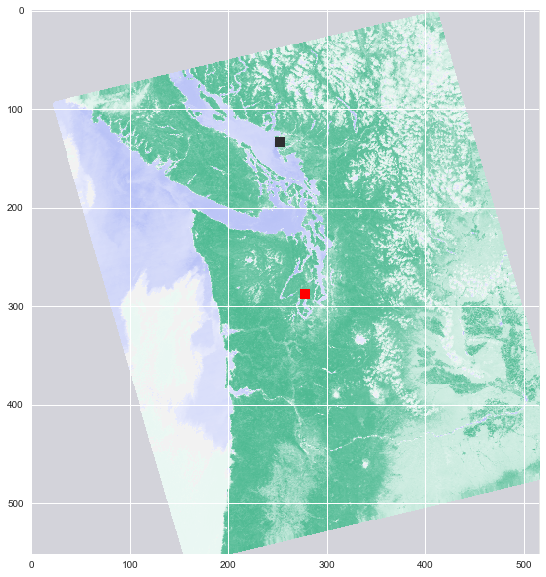

In [10]:
sea_lon,sea_lat=basemap_args['lon_0'],basemap_args['lat_0']
van_lon,van_lat = [-123.2460,49.2606]



sea_col,sea_row=lon_lat_to_row_col(sea_lon,sea_lat,sea_transform,sea_projection)
van_col,van_row=lon_lat_to_row_col(van_lon,van_lat,sea_transform,sea_projection)
sea_col,sea_row,van_col,van_row=int(sea_col),int(sea_row),int(van_col),int(van_row)
sea_ndvi[sea_row:sea_row+10,sea_col:sea_col+10]=5.
sea_ndvi[van_row:van_row+10,van_col:van_col+10]=-5.
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(sea_ndvi,origin='upper',cmap=cmap,norm=the_norm);

#### step 3: we need to move the center south and east so that ubc becomes the new center

In [11]:
delta_lon=sea_lon - van_lon
delta_lat = sea_lat - van_lat
new_lon,new_lat = sea_lon + delta_lon, sea_lat + delta_lat
van_crs={'datum': 'WGS84', 'lat_0': new_lat, 'lon_0': new_lon, 'proj': 'laea', 'units': 'm'}

#### step 4:  do the reprojection

the reproject function requires the x,y corners of the original image
and the resolution

I'll also coarsen the resolution to 5km x 5km

corners: ll_x,ur_x,ll_y,ur_y -356016.462903 314880.871853 -349178.129925 368521.512279


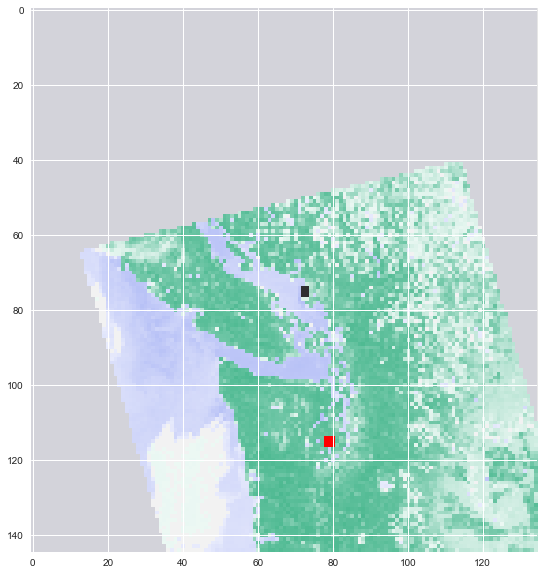

In [12]:
height,width = sea_ndvi.shape
ll_x,ll_y = sea_transform*(0,height)
ur_x,ur_y = sea_transform*(width,0)
print('corners: ll_x,ur_x,ll_y,ur_y',ll_x,ur_x,ll_y,ur_y)


resolution = 5000.,5000.
van_transform, van_width, van_height = calculate_default_transform(sea_crs, van_crs, 
                                         width, height, left=ll_x, bottom= ll_y, right = ur_x, 
                                         top=ur_y,resolution=resolution)
van_ndvi = np.zeros([van_height, van_width],dtype=np.float32)
fill_value = result_dict['fill_value']
out = reproject(sea_ndvi,van_ndvi,src_transform=sea_transform,src_crs=sea_crs,src_nodata=fill_value,dst_nodata=fill_value,
                    dst_transform=van_transform,dest_crs=van_crs,resampling=Resampling.nearest)

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(van_ndvi,origin='upper',cmap=cmap,norm=the_norm);